藤田一弥. (2015). 見えないものをさぐる―それがベイズ ツールによる実践ベイズ統計. 株式会社 オーム社.  
P99 4-2 例題2を利用

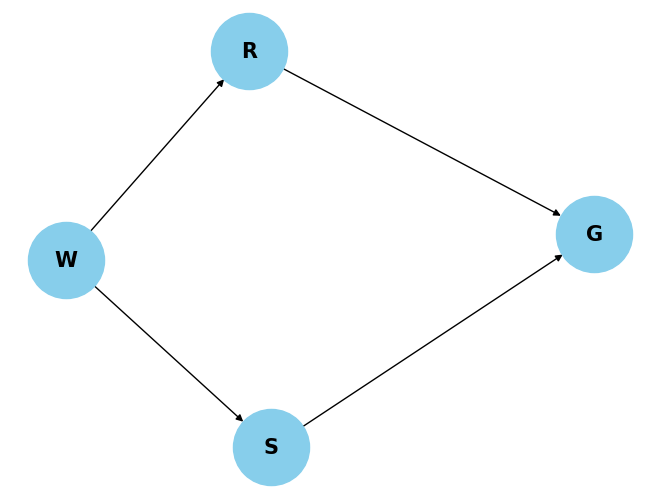

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# ベイジアンネットワークの有向グラフを作成
G = nx.DiGraph()

# ノードを追加
G.add_node("W")
G.add_node("S")
G.add_node("R")
G.add_node("G")

# エッジを追加
G.add_edge("W", "S")
G.add_edge("W", "R")
G.add_edge("S", "G")
G.add_edge("R", "G")

# ベイジアンネットワークを描画
pos = nx.spring_layout(G)  # グラフをレイアウト
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, font_weight="bold")  # グラフを描画
plt.show()


## ベイジアンネットワークでの主な計算
### 条件付き確率の計算 $P(G|W)$
上位の(事前)確率を与えた場合の、下位層の確率を求める  
$P(G|W)=\frac{P(G, W)}{P(W)}\\
= \frac{\sum_{s, r} P(G, W, S, R)}{P(W)}\\
= \frac{\sum_{s, r} P(G | W, S, R)P(W, S, R)}{P(W)}\\
= \frac{\sum_{s, r} P(G | S, R)P(S | W, R)P(W, R)}{P(W)}\\
= \frac{\sum_{s, r} P(G | S, R)P(S | W)P(R | W)P(W)}{P(W)}\\
= \sum_{s, r} P(G | S, R)P(S | W)P(R | W)\\ $
  
具体的には、状態空間を$F$として, ($w, s, r, g \in F$)、$W = w$となる条件付き確率$P(P(G =g | W = w)$を求めるには
$P(G = g|W = w) = \sum_{s, r \in F} P(G = g| S = s, R = r)P(S = s | W = w)P(R = r | W = w)$  
を計算する
### 確率的推論(ベイズ推論) $P(W|G)$
与えられた観測（Gの値）をもとに、ベイズの定理を利用してWの事後確率分布を計算します。推論の目的は、観測されたデータや事実から、未知の変数の確率分布を推定することです。  
$P(W | G ) \\
= \frac{P(G | W )P(W)}{P(G)} \\
= \frac{P(G | W)P(W)}{\sum_w P(G, W)} \\
= \frac{P(G | W)P(W)}{\sum_w P(G | W)P(W)}$  
ここで  
$P(G | W )\\
= \frac{P(G, W)}{P(W)}\\
= \frac{\sum_{s, r} P(G, W, S, R)}{P(W)}\\
= \frac{\sum_{s, r} P(G | W, S, R)P(W, S, R)}{P(W)}\\
= \frac{\sum_{s, r} P(G | S, R)P(S, R | W)P(W)}{P(W)}\\
= \sum_{s, r} P(G | S, R)P(S | W)P(R | W)$
  
これより、  
$P(W | G ) \\
= \frac{\sum_{s, r} P(G | S, R)P(S | W)P(R | W)P(W)}{\sum_w \sum_{s, r} P(G | S, R)P(S | W)P(R | W)P(W)} \\ $
  
となる


In [2]:
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.1 MB/s eta 0:00:00


In [14]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# ベイジアンネットワークのモデルを作成
model = BayesianNetwork()

# ノードを追加
model.add_nodes_from(['W', 'S', 'R', 'G'])

# エッジを追加
model.add_edges_from([('W', 'S'), ('W', 'R'), ('S', 'G'), ('R', 'G')])

# 各ノードの条件付き確率分布を定義(行に変数、列に条件)
cpd_w = TabularCPD(variable='W', variable_card=2, values=[[0.5], [0.5]]) #事前確率
cpd_s = TabularCPD(variable='S', variable_card=2, values=[[0.9, 0.5], [0.1, 0.5]], evidence=['W'], evidence_card=[2]) #[[P(S=0|W=0), P(S=0|W=1)], [P(S=1|W=0), P(S=1|W=1)]]
cpd_r = TabularCPD(variable='R', variable_card=2, values=[[0.2, 0.8], [0.8, 0.2]], evidence=['W'], evidence_card=[2]) #[[P(R=0|W=0), P(R=0|W=1)], [P(R=1|W=0), P(R=1|W=1)]]
cpd_g = TabularCPD(variable='G', variable_card=2, values=[[0.99, 0.1, 0.1, 0.01], [0.01, 0.9, 0.9, 0.99]], evidence=['S', 'R'], evidence_card=[2, 2]) #[[P(G=0|S=0, R=0), P(G=0|S=0, R=1), P(G=0|S=1, R=0), P(G=0|S=1, R=1)], [P(G=1|S=0, R=0), P(G=1|S=0, R=1), P(G=1|S=1, R=0), P(G=1|S=1, R=1)]]

# モデルに条件付き確率分布を追加
model.add_cpds(cpd_w, cpd_s, cpd_r, cpd_g)

# モデルの構造とCPDsが有効であるかをチェック
assert model.check_model()

# ベイジアンネットワークの概要を出力
print(model)


BayesianNetwork with 4 nodes and 4 edges


In [17]:
#P101 (1) P(G = 1 | W = 1)を計算：天気が晴れという条件のもとで、芝が濡れている確率
from pgmpy.inference import VariableElimination

# 推論エンジンの作成
infer = VariableElimination(model)

# P(G = 1 | W = 1)を求める
result = infer.query(variables=['G'], evidence={'W': 1})
print(result)
probability_g_given_w_1 = result.values[1]  # G = 1の確率を取得

print("P(G = 1 | W = 1):", probability_g_given_w_1)

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(0) |   0.4470 |
+------+----------+
| G(1) |   0.5530 |
+------+----------+
P(G = 1 | W = 1): 0.553


In [19]:
#P103 (2) P(G = 1 | W = 0)を計算：天気が晴れでない条件のもとで、芝が濡れている確率
# P(G = 1 | W = 1)を求める
result = infer.query(variables=['G'], evidence={'W': 0})
print(result)
probability_g_given_w_0 = result.values[1]  # G = 1の確率を取得

print("P(G = 1 | W = 0):", probability_g_given_w_0)

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(0) |   0.2530 |
+------+----------+
| G(1) |   0.7470 |
+------+----------+
P(G = 1 | W = 0): 0.747


In [20]:
#P99 確率的推論(事後確率) P(W = 1 | G = 1) 芝が濡れているとき、晴れである確率は？
# P(W = 1 | G = 1)を求める
result = infer.query(variables=['W'], evidence={'G': 1})

probability_w_given_g_1 = result.values[1]  # W = 1の確率を取得

print("P(W = 1 | G = 1):", probability_w_given_g_1)

P(W = 1 | G = 1): 0.42538461538461536


涌井良幸, & 涌井貞美. (2012). 史上最強図解 これならわかる! ベイズ統計学. ナツメ社.  
P170 例題2を参照

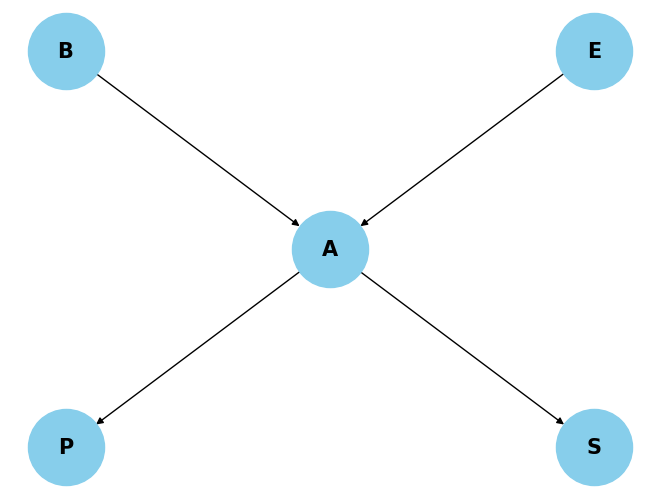

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# ベイジアンネットワークの有向グラフを作成
G2 = nx.DiGraph()

# ノードを追加
G2.add_node("B")
G2.add_node("E")
G2.add_node("A")
G2.add_node("P")
G2.add_node("S")

# エッジを追加
G2.add_edge("B", "A")
G2.add_edge("E", "A")
G2.add_edge("A", "P")
G2.add_edge("A", "S")

# ノードの位置を手動で設定
pos = {"B": (0.5, 2), "E": (1.5, 2), "A": (1, 1), "P": (0.5, 0), "S": (1.5, 0)}

# ベイジアンネットワークを描画
#pos = nx.spring_layout(G2)  # グラフをレイアウト
nx.draw(G2, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, font_weight="bold")  # グラフを描画
plt.show()


In [26]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# ベイジアンネットワークのモデルを作成
model = BayesianNetwork()

# ノードを追加
model.add_nodes_from(['B', 'E', 'A', 'P', 'S'])

# エッジを追加
model.add_edges_from([('B', 'A'), ('E', 'A'), ('A', 'P'), ('A', 'S')])

# 各ノードの条件付き確率分布を定義
cpd_b = TabularCPD(variable='B', variable_card=2, values=[[0.99], [0.01]])  # Bの事前確率
cpd_e = TabularCPD(variable='E', variable_card=2, values=[[0.98], [0.02]])  # Eの事前確率
cpd_a = TabularCPD(variable='A', variable_card=2,
                   values=[[0.92, 0.74, 0.06, 0.05],  # P(A|B, E)
                           [0.08, 0.26, 0.94, 0.95]],
                   evidence=['B', 'E'], evidence_card=[2, 2])
cpd_p = TabularCPD(variable='P', variable_card=2, values=[[0.5, 0.5], [0.5, 0.5]], evidence=['A'], evidence_card=[2])  # Pの条件付き確率(今回は未設定)
cpd_s = TabularCPD(variable='S', variable_card=2, values=[[0.9, 0.3], [0.1, 0.7]], evidence=['A'], evidence_card=[2])  # Sの条件付き確率

# モデルに条件付き確率分布を追加
model.add_cpds(cpd_b, cpd_e, cpd_a, cpd_p, cpd_s)

# モデルの構造とCPDsが有効であるかをチェック
assert model.check_model()

# ベイジアンネットワークの概要を出力
print(model)


BayesianNetwork with 5 nodes and 4 edges


In [28]:
#P(B | S) セキュリティ会社に連絡がいったとき、泥棒が入った確率
from pgmpy.inference import VariableElimination

# 推論エンジンの作成
infer = VariableElimination(model)

# P(B | S)を求める
result = infer.query(variables=['B'], evidence={'S': 1})

probability_b_given_s = result.values[1]  # B = 1の確率を取得

print("P(B = 1 | S = 1):", probability_b_given_s)

P(B = 1 | S = 1): 0.042763793338810904


$P(W = s | G = t) \\
= \frac{P(G = t | W = s)P(W = s)}{P(G = t)} \\
= \frac{P(G = t | W = s)P(W = s)}{P(G = t, W = s) + P(G = t, W \neq s)} \\
= \frac{P(G = t | W = s)P(W = s)}{P(G = t | W = s)P(W = s) + P(G = t | W \neq s)P(W \neq s)}$  

$P(G = t | W = s)\\
= \frac{P(G = t, W = s)}{P(W = s)}\\
= \frac{\sum_{i, j} P(G = t, W = s, S = i, R = j)}{P(W = s)}\\
= \frac{\sum_{i, j} P(G = t | W = s, S = i, R = j)P(W = s, S = i, R = j)}{P(W = s)}\\
= \frac{\sum_{i, j} P(G = t | S = i, R = j)P(S = i, R = j | W = s)P(W = s)}{P(W = s)}\\
= \sum_{i, j} P(G = t | S = i, R = j)P(S = i | W = s)P(R = j | W = s)$
  
同様に、$P(G = t | W \neq s)$も求める
$P(G = t | W \neq s) = \sum_{i, j} P(G = t | S = i, R = j)P(S = i | W \neq s)P(R = j | W \neq s)$
  
以下の条件付き独立を使っている.  
$P(S, R | W) = P(S|W)P(R|W)\\
P(G | W, S, R) = P(G | S, R)$
  
注意：事前確率は$P(W)$しかわかっていない。$P(G)$の事前確率はわからないから、全確率の公式で分解する。

推論 ： 与えられた観測（Gの値）をもとに、ベイズの定理を利用してWの事後確率分布を計算します。推論の目的は、観測されたデータや事実から、未知の変数の確率分布を推定することです。

   TransactionCount  DayType  MorningSales  Item1Sales  Item2Sales
0               102        0            33          19          23
1               193        0            36          37          44
2               171        0            65          17          16
3               189        0            34          38          40
4               126        0            84          30          29
   TransactionCount_bin  DayType_bin  MorningSales_bin  Item1Sales_bin  \
0                     1            0                 0               0   
1                     2            0                 0               2   
2                     2            0                 1               0   
3                     2            0                 0               2   
4                     1            0                 2               1   

   Item2Sales_bin  
0               1  
1               2  
2               0  
3               2  
4               1  
BIC = 


  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 5 nodes and 0 edges
BIC = -5111.856671456013


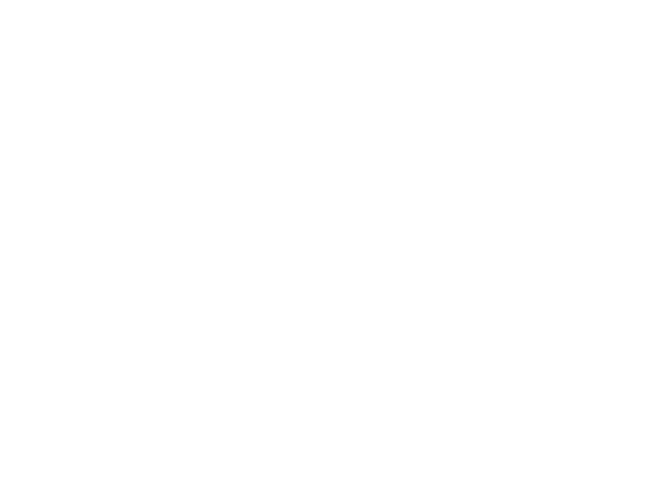

In [31]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
import networkx as nx
import matplotlib.pyplot as plt

# 疑似データ生成関数
def generate_data(num_samples=1000):
    # ランダムな日毎のトランザクション数
    transaction_count = np.random.randint(50, 200, size=num_samples)

    # ランダムなDayType (0: weekday, 1: weekend)
    day_type = np.random.choice([0, 1], size=num_samples)

    # ランダムなDaypartのそれぞれの販売個数/日(Morning, afternoon, evening, nightそれぞれの販売個数)
    morning_sales = np.random.randint(20, 100, size=num_samples)

    # ランダムなそれぞれのItemでの販売個数/日
    item_sales = np.random.randint(5, 50, size=(num_samples, 4))

    # 生成したデータをDataFrameに格納
    data = pd.DataFrame({
        'TransactionCount': transaction_count,
        'DayType': day_type,
        'MorningSales': morning_sales,
        'Item1Sales': item_sales[:, 0],
        'Item2Sales': item_sales[:, 1],

    })

    return data

# 疑似データ生成
data = generate_data()

# 生成したデータの確認
print(data.head())

# ビンの数
num_bins = 3

# データをビンに分割
binned_data = pd.DataFrame()
for column in data.columns:
    binned_data[column] = pd.cut(data[column], num_bins, labels=False)

# ラベルの割り当て
binned_data.columns = [f"{column}_bin" for column in binned_data.columns]

# 離散化したデータの確認
print(binned_data.head())

# BicScoreオブジェクトを作成
bic = BicScore(binned_data)
print('BIC = '.format(bic))

# HillClimbSearchを使用してベイジアンネットワークの学習を行う
hc = HillClimbSearch(binned_data)
best_model = hc.estimate(scoring_method=bic)

# 学習したネットワークの可視化
print(best_model)
print('BIC =', bic.score(best_model))

# ベイジアンネットワークを可視化
# ベイジアンネットワークの有向グラフを作成
G = nx.DiGraph(best_model.edges())

# ベイジアンネットワークを描画
pos = nx.spring_layout(G)  # グラフをレイアウト
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, font_weight="bold")  # グラフを描画
plt.show()
